Step 1: Generating the desired datasets

In [3]:
from sklearn.datasets import make_circles, make_moons, make_blobs

# Dataset 1: make_circles
circles_data, _ = make_circles(n_samples=500, factor=0.3, noise=0.07, random_state=42)

# Dataset 2: make_moons
moons_data, _ = make_moons(n_samples=500, noise=0.05, random_state=42)

# Dataset 3: make_blobs
blobs_data, _ = make_blobs(n_samples=500, 
                           centers=[(-6, 2), (-1, 5), (5, -4)], 
                           cluster_std=[0.5, 1.5, 2.0], 
                           random_state=42)

# Dictionary for better access
datasets = {
    "make_blobs": blobs_data,
    "make_moons": moons_data,
    "make_circles": circles_data
}


Step 2: Scatter Plots without labels

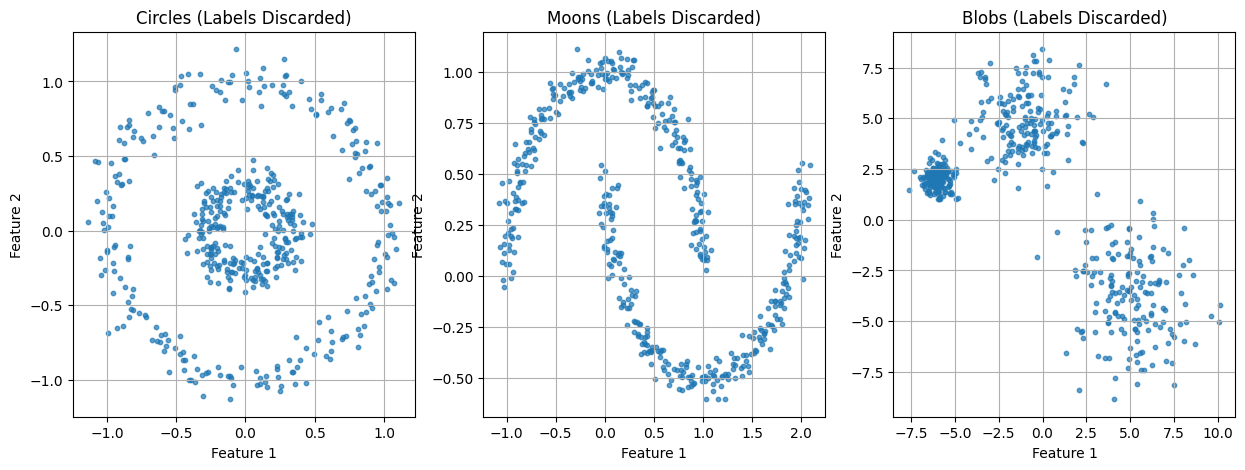

In [5]:
import matplotlib.pyplot as plt

# Plotting function
def plot_data(data, labels=None, title="", ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    if labels is not None:
        scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap="viridis", s=10, alpha=0.7)
    else:
        scatter = ax.scatter(data[:, 0], data[:, 1], s=10, alpha=0.7)
    
    ax.set_title(title)
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    ax.grid(True)
    
    return scatter

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot datasets without labels
plot_data(circles_data,None, "Circles (Labels Discarded)", axes[0])
plot_data(moons_data, None,"Moons (Labels Discarded)", axes[1])
plot_data(blobs_data, None,"Blobs (Labels Discarded)", axes[2])


Step 3: AP Function implementation

In [ ]:
import numpy as np
def compute_similarity_matrix(data, method="gaussian", sigma=1.0):
    """
    Compute the similarity matrix using the specified method.
    
    Parameters:
        data (numpy.ndarray): Dataset of shape (n_samples, n_features).
        method (str): Similarity measure ('gaussian', 'cosine', or 'euclidean').
        sigma (float): Parameter for Gaussian kernel (used only if method='gaussian').
        
    Returns:
        numpy.ndarray: Similarity matrix of shape (n_samples, n_samples).
    """
    n_samples = data.shape[0]
    if method == "gaussian":
        # Compute squared Euclidean distance
        dists = np.linalg.norm(data[:, None, :] - data[None, :, :], axis=2) ** 2
        S = np.exp(-dists / (2 * sigma ** 2))  # Gaussian kernel similarity
    elif method == "cosine":
        # Normalize the data
        norms = np.linalg.norm(data, axis=1, keepdims=True)
        normalized_data = data / norms
        S = np.dot(normalized_data, normalized_data.T)  # Cosine similarity
    elif method == "euclidean":
        S = np.linalg.norm(data[:, None, :] - data[None, :, :], axis=2) ** 2
    else:
        raise ValueError(f"Unknown similarity method: {method}")
    return S

def affinity_propagation(S, max_iter=300, damping=0.9, convergence_iter=20):
    """
    Affinity Propagation clustering algorithm.
    
    Parameters:
        S (numpy.ndarray): Similarity matrix (n_samples x n_samples).
        max_iter (int): Maximum number of iterations.
        damping (float): Damping factor (0.5 <= damping < 1).
        convergence_iter (int): Number of iterations to check for convergence.
    
    Returns:
        numpy.ndarray: Cluster centers indices.
        numpy.ndarray: Labels for each sample.
    """


    n_samples = S.shape[0]
    A = np.zeros((n_samples, n_samples))  # Availability matrix
    R = np.zeros((n_samples, n_samples))  # Responsibility matrix
    diag_indices = np.arange(n_samples)
    
    # Set preferences (diagonal of S) to median similarity
    np.fill_diagonal(S, np.min(S)*1.5)

    for it in range(max_iter):
        # Step 1: Update Responsibilities
        old_R = R.copy()
        for i in range(n_samples):
            for k in range(n_samples):
                mask = np.arange(n_samples) != k
                R[i, k] = S[i, k] - np.max(A[i, mask] + S[i, mask])
        
        R = (1 - damping) * R + damping * old_R
        
        # Step 2: Update Availabilities
        old_A = A.copy()
        for i in range(n_samples):
            for k in range(n_samples):
                if i == k:
                    A[i, k] = np.sum(np.maximum(0, R[:, k][np.arange(n_samples) != k]))
                else:
                    A[i, k] = min(0, R[k, k] + np.sum(np.maximum(0, R[:, k][(np.arange(n_samples) != k) & (np.arange(n_samples) != i)])))
        
        A = (1 - damping) * A + damping * old_A
        
        # Step 3: Check for Convergence
        E = (A + R) > 0  # Exemplars
        exemplars = np.where(np.diag(E) == True)[0]
        if len(exemplars) > 0 and it >= convergence_iter:
            cluster_count = np.sum(E[:, exemplars], axis=0)
            if np.all(cluster_count >= convergence_iter):
                break
    
    # Assign clusters
    exemplars = np.where(np.diag(A + R) > 0)[0]
    labels = np.argmax(S[:, exemplars], axis=1) if len(exemplars) > 0 else np.full(n_samples, -1)
    
    return exemplars, labels

    
    
    


Step 4: Finding the best combination of hyperparameters

In [125]:
import itertools
from sklearn.datasets import make_circles, make_moons, make_blobs


datasets = {
    "make_blobs": make_blobs(n_samples=500, centers=[(-6, 2), (-1, 5), (5, -4)], 
                           cluster_std=[0.5, 1.5, 2.0],random_state=42)[0],
    "make_moons": make_moons(n_samples=500, noise=0.05, random_state=42)[0],
    "make_circles": make_circles(n_samples=500, noise=0.07, factor=0.3, random_state=42)[0]
}
preferences = np.linspace(np.min(S), np.max(S), 5)
damping_values = [0.5, 0.7, 0.8, 0.9]
best_results = {}
one_cluster_results = {}

for name, data in datasets.items():
    results = []
    single_cluster_results = []
    for p, damping in itertools.product(preferences, damping_values):
        S = compute_similarity_matrix(data, method="euclidean")
        np.fill_diagonal(S, p)  # Set diagonal to preference value
        exemplars, labels = affinity_propagation(S, damping=damping)
        num_clusters = len(set(labels))
        if num_clusters == 1:
            single_cluster_results.append({"preference": p, "damping": damping, "num_clusters": num_clusters})
        elif num_clusters > 1:  # Ensure at least 2 clusters
            results.append({"preference": p, "damping": damping, "num_clusters": num_clusters})

    # Find the best configuration for this dataset (minimizing number of clusters)
    if results:  # Check if there are valid results with more than 1 cluster
        best_config = min(results, key=lambda x: x['num_clusters'])
        best_results[name] = best_config
    else:
        best_results[name] = "No valid configuration found with more than 1 cluster"

    # Store configurations that resulted in exactly 1 cluster
    one_cluster_results[name] = single_cluster_results

# Print the best results for each dataset
for dataset_name, config in best_results.items():
    print(f"Dataset: {dataset_name}, Best Configuration: {config}")

# Print configurations that resulted in 1 cluster
for dataset_name, configs in one_cluster_results.items():
    if configs:
        print(f"\nDataset: {dataset_name}, Configurations with 1 Cluster:")
        for config in configs:
            print(config)

Dataset: make_blobs, Best Configuration: {'preference': 0.0015571144959677877, 'damping': 0.5, 'num_clusters': 4}
Dataset: make_moons, Best Configuration: {'preference': 0.0015571144959677877, 'damping': 0.5, 'num_clusters': 3}
Dataset: make_circles, Best Configuration: {'preference': 0.0015571144959677877, 'damping': 0.5, 'num_clusters': 6}


Step 5: Evaluation


Dataset: make_blobs
Affinity Propagation Results:
  Silhouette Coefficient: -0.07
  Calinski-Harabasz Index: 0.43
  Davies-Bouldin Index: 49.69
K-means Results:
  Silhouette Coefficient: 0.50
  Calinski-Harabasz Index: 1551.78
  Davies-Bouldin Index: 0.86
HDBSCAN Results:
  Silhouette Coefficient: 0.57
  Calinski-Harabasz Index: 1035.74
  Davies-Bouldin Index: 7.08

Dataset: make_moons
Affinity Propagation Results:
  Silhouette Coefficient: -0.03
  Calinski-Harabasz Index: 1.51
  Davies-Bouldin Index: 29.83
K-means Results:
  Silhouette Coefficient: 0.53
  Calinski-Harabasz Index: 1085.34
  Davies-Bouldin Index: 0.57
HDBSCAN Results:
  Silhouette Coefficient: 0.33
  Calinski-Harabasz Index: 332.49
  Davies-Bouldin Index: 1.15

Dataset: make_circles
Affinity Propagation Results:
  Silhouette Coefficient: 0.19
  Calinski-Harabasz Index: 151.57
  Davies-Bouldin Index: 1.55
K-means Results:
  Silhouette Coefficient: 0.42
  Calinski-Harabasz Index: 393.45
  Davies-Bouldin Index: 0.80
HDBSC

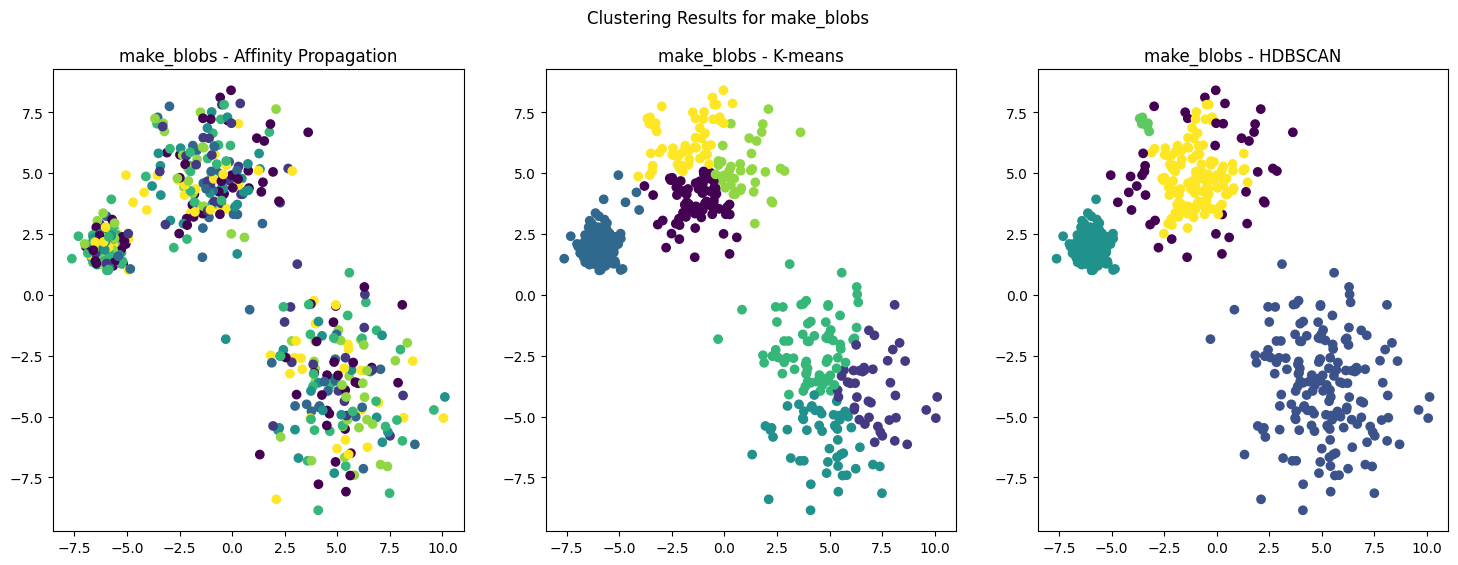

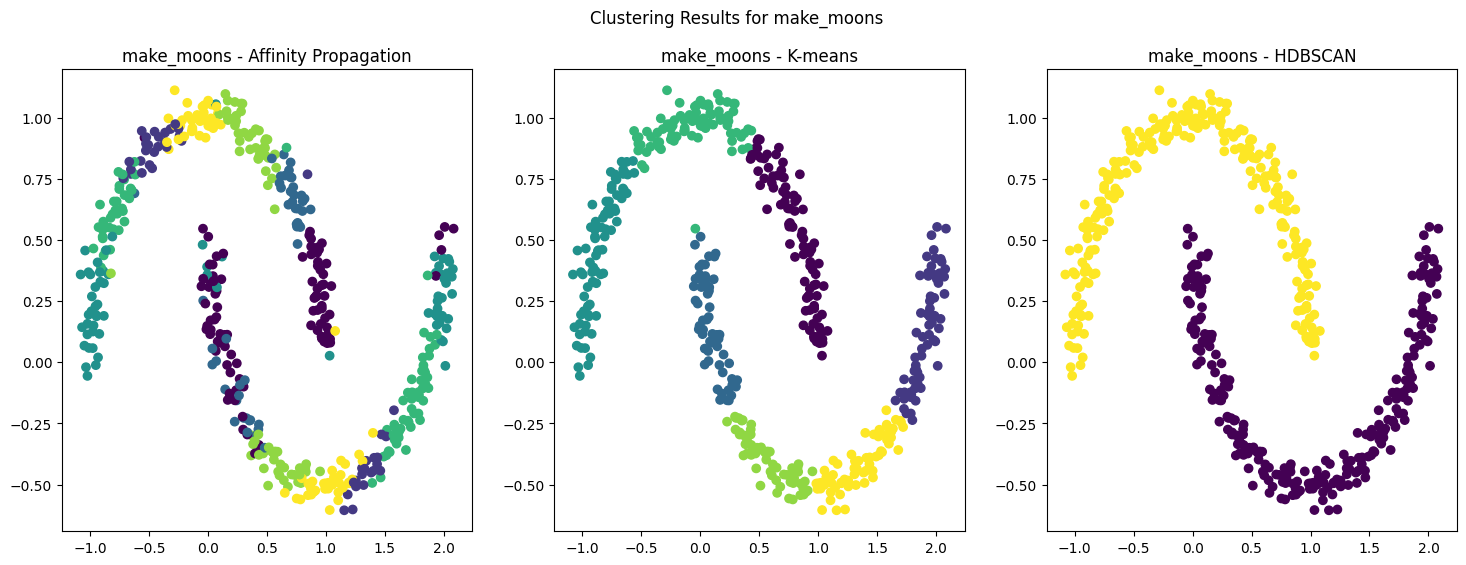

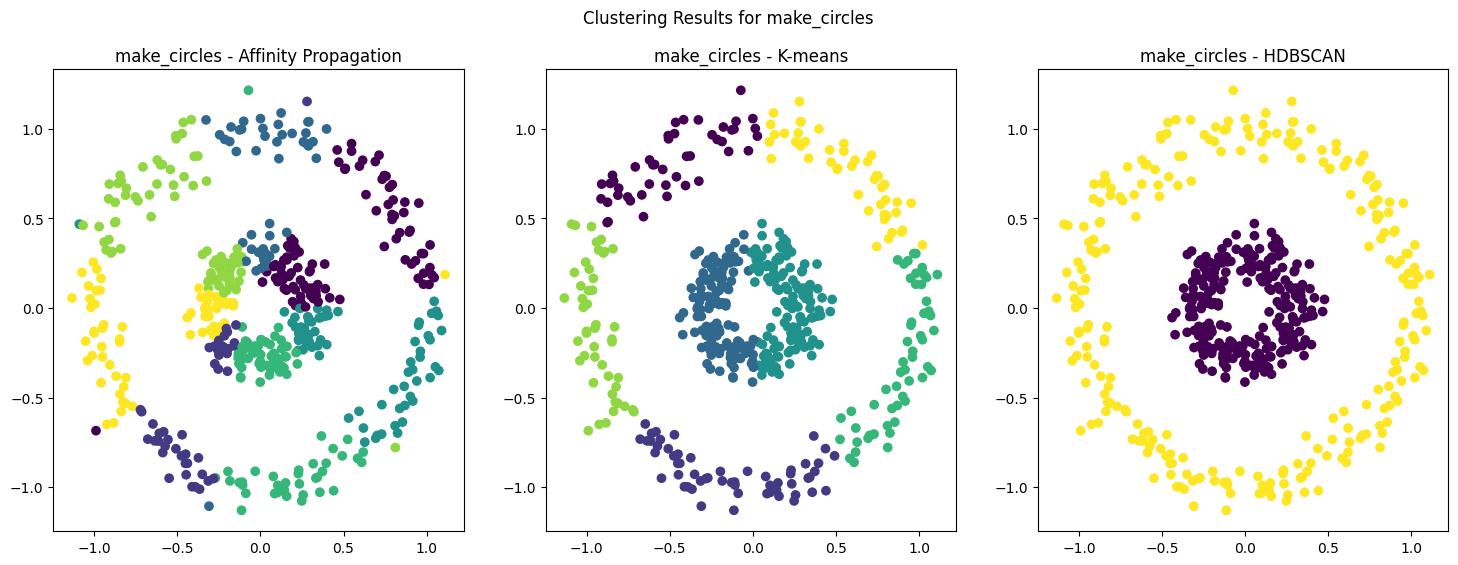

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
import hdbscan

#  Helper function to evaluate and visualize clustering results
def evaluate_clustering(data, labels, algorithm_name):
    silhouette = silhouette_score(data, labels)
    calinski = calinski_harabasz_score(data, labels)
    davies = davies_bouldin_score(data, labels)
    print(f"{algorithm_name} Results:")
    print(f"  Silhouette Coefficient: {silhouette:.2f}")
    print(f"  Calinski-Harabasz Index: {calinski:.2f}")
    print(f"  Davies-Bouldin Index: {davies:.2f}")
    return silhouette, calinski, davies



#  Run clustering and evaluation
for name, data in datasets.items():
    print(f"\nDataset: {name}")
    
    # Create subplots (1 row, 3 columns)
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f"Clustering Results for {name}")

    # Affinity Propagation
    S = compute_similarity_matrix(data, method="euclidean")
    exemplars,ap_labels = affinity_propagation(S,damping=0.5)
    ap_labels = ap.labels_
    axes[0].scatter(data[:, 0], data[:, 1], c=ap_labels, cmap='viridis')
    axes[0].set_title(f"{name} - Affinity Propagation")    
    evaluate_clustering(data, ap_labels, "Affinity Propagation")
    
    # K-means
    kmeans = KMeans(n_clusters=len(np.unique(ap_labels)), random_state=42,n_init="auto")
    kmeans_labels = kmeans.fit_predict(data)
    axes[1].scatter(data[:, 0], data[:, 1], c=kmeans_labels, cmap='viridis')
    axes[1].set_title(f"{name} - K-means")
    evaluate_clustering(data, kmeans_labels, "K-means")

    
    # HDBSCAN
    clusterer = hdbscan.HDBSCAN()
    hdbscan_labels = clusterer.fit_predict(data)
    axes[2].scatter(data[:, 0], data[:, 1], c=hdbscan_labels, cmap='viridis')
    axes[2].set_title(f"{name} - HDBSCAN")
    evaluate_clustering(data, hdbscan_labels, "HDBSCAN")


Additonal Note Code

In [122]:
import itertools
from sklearn.metrics import silhouette_score

preferences = np.linspace(np.min(S), np.max(S), 5)
damping_values = [0.5, 0.7, 0.8, 0.9]
# sigmas = [0.1, 0.5, 1.0]
results = []

for  p, damping in itertools.product( preferences, damping_values):
    S = compute_similarity_matrix(moons_data, method="euclidean")
    np.fill_diagonal(S, p)
    exemplars, labels = affinity_propagation(S, damping=damping)
    silhouette = silhouette_score(moons_data, labels)
    results.append({"preference": p, "damping": damping, "silhouette": silhouette})

# Find the best combination
best_config = max(results, key=lambda x: x['silhouette'])
print(f"Best configuration: {best_config}")


Best configuration: {'preference': 2.9646978720861874e-06, 'damping': 0.5, 'silhouette': 0.4433740337089557}
